# Fast Wavelet-Based Classification of Radar Echoes into Convection Core, Mixed-Intermediate and Stratiform Classes

This cookbook demonstrates the wavelet-based radar echo classification method from Raut et al. (2008 and 2020) [1, 2]. 


## Introduction:
In radar data, convective regions are characterized by horizontal inhomogeneity, generally high reflectivity than surrounding echoes, and vertical growth, as opposed to the more horizontally homogeneous stratiform regions. Historically, radar echoes were classified into convective and stratiform categories using reflectivity thresholds, typically around 40 dBZ. However, this approach is not reliable as significant fraction of convection has reflectivities comparable to stratiform rain below the 40dBZ threshold. To address these challenges, algorithms that consider the horizontal reflectivity structure as an additinal criteria were developed although the threshold was still used as the primary criteria [3, 4, 5]. 

The rain exhibit a wide range of spatial frequencies, or scales, embedded within self-similar structures [6] and convection and stratiform can be identified by the scale analysis of the images. Fourier transform (FT), although can compute the power spectrum of these images to study the dominant frequencies, cannot identify localized structure within the image. A multiresolution approximation separates features of different scales within the image. Wavelets iteratively decompose the image into different resolutions or scales. The á trous wavelet transform (WT) is particularly prominent in astrophysics and medical imaging.

## The Á Trous Wavelet Transform
The á trous wavelet transform, as proposed by Shensa [7] and further developed by Starck and Murtagh [8], is utilized in this algorithm. This algorithm employs a scaling function at dyadically increasing scales to approximate the original image at successively coarser resolutions and the wavelet coefficients at a given scale are the difference between two successive approximations.

This has significant implications for meteorological analysis, particularly in the classification of convection from stratiform regions in radar and satellite data. The multiresolution analysis offers an objective classification scheme to classify embedded or isolated convection without the need for specific conditions and intensity thresholds.

## Classification Scheme

1. **Transform Reflectivity to Rain Field**: The first step involves transforming the reflectivity field into a rain field. The standard ZR relationship should work for most radars.

 2. **Compute Wavelet Transform (WT) of the Rain Field**: 
The WT is computed for the rain field across `n` different scales, where `n` can be 15-30 kilometers as discussed in Raut et al (2018) [9]. This process breaks down the rain field into various scales.

3. **Sum of Wavelet Scales (wt_sum)**: 
The next step is to sum up all these 'n' wavelet scales. 

4. The classification of the precipitation type is then determined based on `wt_sum` and the original dBZ values (`vol_data`):

     - **Unclassified**: If `reflectivity < min_dbz_threshold`, the precipitation is too low to be classified.
     - **Convective Core**: If `wt_sum ≥ conv_wt_threshold AND reflectivity > conv_dbz_threshold`, the precipitation is classified as 'Convective Core'. This implies a higher intensity and potentially active collision and coalescence.
     - **Mix or Intermediate**: If `conv_wt_threshold > wt_sum ≥ tran_wt_threshold AND reflectivity > conv_dbz_threshold`, the precipitation is categorized as 'Intermediate or Mix Convective'. This rain is not as intense as convective core but it has more significant liquid water content than stratiform.
     - **Stratiform**: If `wt_sum < tran_wt_threshold AND reflectivity > min_dbz_threshold`, the precipitation is classified as 'Stratiform or non-convective'. This is typically more uniform and less intense than convective class.



# Test Examples

In [1]:
import numpy as np

import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



# Case 1


### Reading and Preparing Radar Data
We load a sample radar data file using Py-ART, extracts the lowest sweep, and then interpolates this data onto a cartesian grid. The dx and dy variables represent the grid resolution in the x and y directions, respectively.

In [2]:
# read in the test file
filename = pyart.testing.get_test_data("swx_20120520_0641.nc")
radar = pyart.io.read(filename)

# extract the lowest sweep
radar = radar.extract_sweeps([0])

# interpolate to grid
grid = pyart.map.grid_from_radars(
    (radar,),
    grid_shape=(1, 201, 201),
    grid_limits=((0, 10000), (-50000.0, 50000.0), (-50000.0, 50000.0)),
    fields=["reflectivity_horizontal"],
)

# get dx dy
dx = grid.x["data"][1] - grid.x["data"][0]
dy = grid.y["data"][1] - grid.y["data"][0]

#### Using `Peak Feature Detection`
Lets now performs convective-stratiform classification on the radar data using the Yuter method [4, 5], which is a part of Py-ART's retrieve module. The result is added to the grid as a new field for further analysis or visualization.


In [3]:
# convective stratiform classification Yuter
convsf_dict = pyart.retrieve.conv_strat_yuter(
    grid,
    dx,
    dy,
    refl_field="reflectivity_horizontal",
    always_core_thres=40,
    bkg_rad_km=20,
    use_cosine=True,
    max_diff=3,
    zero_diff_cos_val=55,
    weak_echo_thres=5,
    max_conv_rad_km=2,
    estimate_flag=False,
)

grid.add_field("convsf", convsf_dict["feature_detection"], replace_existing=True)

/Users/bhupendra/anaconda3/envs/pyart/lib/python3.12/site-packages/scipy/ndimage/_filters.py:1769: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


#### Using `Wavelet Scale Analysis`
The function processes radar data using a Py-ART Grid object and a specified reflectivity field (`refl_field`). It offers options to adjust the Z-R relationship coefficients (`zr_a` and `zr_b`) and various thresholds for tailored classification. The output is a dictionary, `reclass_dict`, ready for integration into a Py-ART Grid. This dictionary includes the classification results, a description of the categories, and a record of the used parameters for transparency and reference.


In [4]:
reclass_dict = pyart.retrieve.conv_strat_raut(
    grid, refl_field="reflectivity_horizontal"
)

# add field
grid.add_field("wt_reclass", reclass_dict["wt_reclass"], replace_existing=True)
reclass_dict["wt_reclass"]

/Users/bhupendra/projects/pyart/pyart/retrieve/_echo_class_wt.py:175: RuntimeWarning: invalid value encountered in cast
  return wt_class.astype(np.int32)


{'data': masked_array(
   data=[[[--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          ...,
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --]]],
   mask=[[[ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True],
          ...,
          [ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True]]],
   fill_value=999999,
   dtype=int32),
 'standard_name': 'wavelet_echo_class',
 'long_name': 'Wavelet-based multiresolution radar echo classification',
 'valid_min': 0,
 'valid_max': 3,
 'classification_description': '0: Unclassified, 1: Stratiform, 2: Mixed-Intermediate, 3: Convective Cores',
 'parameters': {'refl_field': 'reflectivity_hori

The classification parameters are returned in the dictionary along with the masked array. Although `conv_scale_km` was set to `25`, the algorithm calculated the `scale_break` as `32km`. This variation depends on the data resolution. Parameters outside the specified range will automatically be adjusted to fall within the permissible range. To disable this automatic adjustment and override the range checks, set `override_checks` to `True`.


# Plotting 


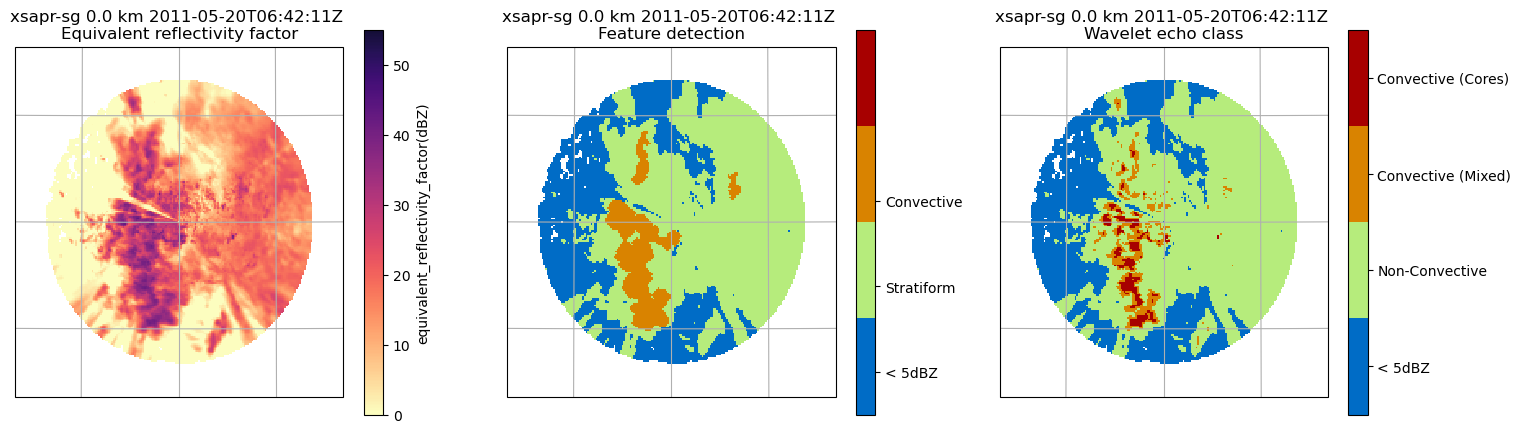

In [5]:
# Required imports

import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

display = pyart.graph.GridMapDisplay(grid)

# Create a colormap for reflectivity
magma_r_cmap = plt.get_cmap("magma_r")
ref_cmap = mcolors.LinearSegmentedColormap.from_list(
    "ref_cmap", magma_r_cmap(np.linspace(0, 0.9, magma_r_cmap.N))
)

# Define the projection
projection = ccrs.AlbersEqualArea(
    central_latitude=radar.latitude["data"][0],
    central_longitude=radar.longitude["data"][0],
)

# Create a figure with a 2x2 layout
plt.figure(figsize=(18, 5))

# First panel - Reflectivity (Top Left)
ax1 = plt.subplot(1, 3, 1, projection=projection)
display.plot_grid(
    "reflectivity_horizontal",
    vmin=0,
    vmax=55,
    cmap=ref_cmap,
    transform=ccrs.PlateCarree(),
    ax=ax1,
)

# Second panel - CSY (Top Right)
ax2 = plt.subplot(1, 3, 2, projection=projection)
display.plot_grid(
    "convsf",
    vmin=0,
    vmax=3,
    cmap=plt.get_cmap("pyart_HomeyerRainbow", 4),
    ax=ax2,
    transform=ccrs.PlateCarree(),
    ticks=[1 / 3, 1, 5 / 3],
    ticklabs=["< 5dBZ", "Stratiform", "Convective"],
)

# Third panel - WT (Bottom Left)
ax3 = plt.subplot(1, 3, 3, projection=projection)
display.plot_grid(
    "wt_reclass",
    vmin=0,
    vmax=4,
    cmap=plt.get_cmap("pyart_HomeyerRainbow", 4),
    ax=ax3,
    transform=ccrs.PlateCarree(),
    ticks=[0.5, 1.5, 2.5, 3.5],
    ticklabs=["< 5dBZ", "Non-Convective", "Convective (Mixed)", "Convective (Cores)"],
)

# Show the plot
plt.show()

# Case 2


In [6]:
# Read in file
nexrad_file = "s3://noaa-nexrad-level2/2022/09/28/KTBW/KTBW20220928_190142_V06"
radar = pyart.io.read_nexrad_archive(nexrad_file)

# extract the lowest sweep
radar = radar.extract_sweeps([0])

# interpolate to grid
grid = pyart.map.grid_from_radars(
    (radar,),
    grid_shape=(1, 201, 201),
    grid_limits=((0, 10000), (-200000.0, 200000.0), (-200000.0, 200000.0)),
    fields=["reflectivity"],
)

# get dx dy
dx = grid.x["data"][1] - grid.x["data"][0]
dy = grid.y["data"][1] - grid.y["data"][0]

In [7]:
# convective stratiform classification Yuter
convsf_dict = pyart.retrieve.conv_strat_yuter(
    grid,
    dx,
    dy,
    refl_field="reflectivity",
    always_core_thres=40,
    bkg_rad_km=20,
    use_cosine=True,
    max_diff=3,
    zero_diff_cos_val=55,
    weak_echo_thres=5,
    max_conv_rad_km=2,
    estimate_flag=False,
)


# add to grid object
# mask zero values (no surface echo)
convsf_masked = np.ma.masked_equal(convsf_dict["feature_detection"]["data"], 0)
# mask 3 values (weak echo)
convsf_masked = np.ma.masked_equal(convsf_masked, 3)
# add dimension to array to add to grid object
convsf_dict["feature_detection"]["data"] = convsf_masked
# add field
grid.add_field("convsf", convsf_dict["feature_detection"], replace_existing=True)

/Users/bhupendra/anaconda3/envs/pyart/lib/python3.12/site-packages/scipy/ndimage/_filters.py:1769: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


In [8]:
reclass_dict = pyart.retrieve.conv_strat_raut(grid, refl_field="reflectivity")

# add field
grid.add_field("wt_reclass", reclass_dict["wt_reclass"], replace_existing=True)
reclass_dict

/Users/bhupendra/projects/pyart/pyart/retrieve/_echo_class_wt.py:175: RuntimeWarning: invalid value encountered in cast
  return wt_class.astype(np.int32)


{'wt_reclass': {'data': masked_array(
    data=[[[--, --, --, ..., --, --, --],
           [--, --, --, ..., --, --, --],
           [--, --, --, ..., --, --, --],
           ...,
           [--, --, --, ..., 1, 1, 1],
           [--, --, --, ..., 1, 1, 1],
           [--, --, --, ..., 1, 1, 1]]],
    mask=[[[ True,  True,  True, ...,  True,  True,  True],
           [ True,  True,  True, ...,  True,  True,  True],
           [ True,  True,  True, ...,  True,  True,  True],
           ...,
           [ True,  True,  True, ..., False, False, False],
           [ True,  True,  True, ..., False, False, False],
           [ True,  True,  True, ..., False, False, False]]],
    fill_value=999999,
    dtype=int32),
  'standard_name': 'wavelet_echo_class',
  'long_name': 'Wavelet-based multiresolution radar echo classification',
  'valid_min': 0,
  'valid_max': 3,
  'classification_description': '0: Unclassified, 1: Stratiform, 2: Mixed-Intermediate, 3: Convective Cores',
  'parameters': {'ref

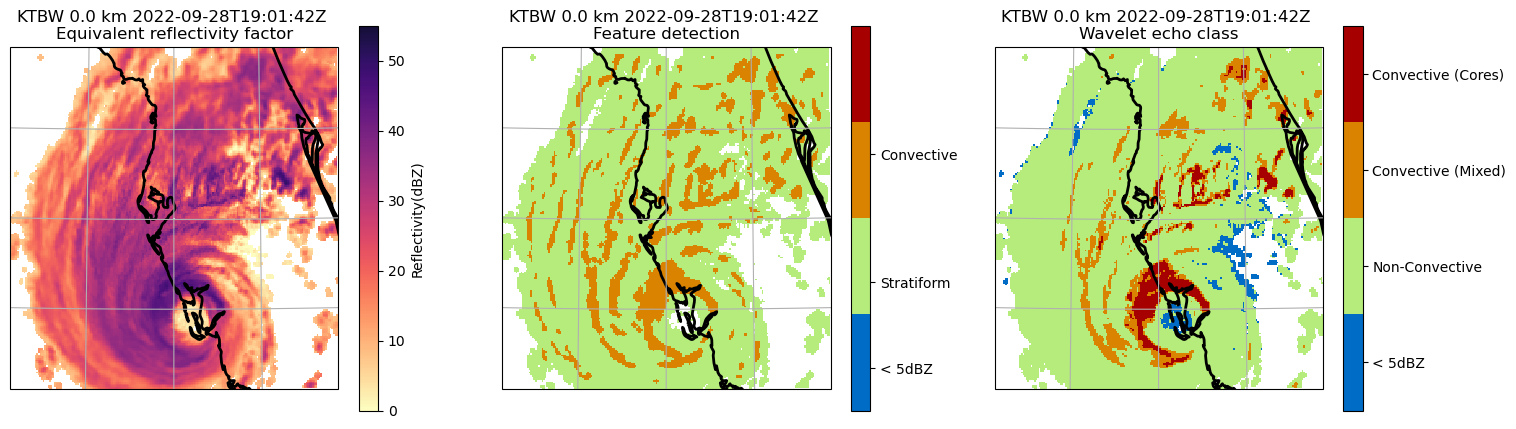

In [9]:
# Required imports

display = pyart.graph.GridMapDisplay(grid)

# Create a colormap for reflectivity
magma_r_cmap = plt.get_cmap("magma_r")
ref_cmap = mcolors.LinearSegmentedColormap.from_list(
    "ref_cmap", magma_r_cmap(np.linspace(0, 0.9, magma_r_cmap.N))
)

# Define the projection
projection = ccrs.AlbersEqualArea(
    central_latitude=radar.latitude["data"][0],
    central_longitude=radar.longitude["data"][0],
)

# Create a figure with a 2x2 layout
plt.figure(figsize=(18, 5))

# First panel - Reflectivity (Top Left)
ax1 = plt.subplot(1, 3, 1, projection=projection)
display.plot_grid(
    "reflectivity", vmin=0, vmax=55, cmap=ref_cmap, transform=ccrs.PlateCarree(), ax=ax1
)

# Second panel - csy (Bottom Left)
ax2 = plt.subplot(1, 3, 2, projection=projection)
display.plot_grid(
    "convsf",
    vmin=0,
    vmax=3,
    cmap=plt.get_cmap("pyart_HomeyerRainbow", 4),
    ax=ax2,
    transform=ccrs.PlateCarree(),
    ticks=[1 / 3, 1, 2],
    ticklabs=["< 5dBZ", "Stratiform", "Convective"],
)

# third  panel - reclass (Bottom Right)
ax3 = plt.subplot(1, 3, 3, projection=projection)
display.plot_grid(
    "wt_reclass",
    vmin=0,
    vmax=4,
    cmap=plt.get_cmap("pyart_HomeyerRainbow", 4),
    ax=ax3,
    transform=ccrs.PlateCarree(),
    ticks=[0.5, 1.5, 2.5, 3.5],
    ticklabs=["< 5dBZ", "Non-Convective", "Convective (Mixed)", "Convective (Cores)"],
)

# Show the plot
plt.show()

# Remarks:
Both the methods primarily agree on the location of the convection; however, the wavelet transform reveals more intricate details in the shape of the identified convective regions. The further separation of convection into `cores` and `intermediate-mixed` category is particularly notable. The comparison of Drop Size Distributions (DSD) for these classes shows the WT method's efficiency in segregating radar rainfall regions that are microphysically distinct [2]. The stratiform or non-convective precipitation, characterized by smaller drops and the lowest drop density, contrasts with convective core precipitation, which exhibits a high drop density and abundance of large drops. The intermediate or mixed rain category, marked by a high concentration of small and medium size drops and a lack of large drops, provides further insights into the microphysical processes and the convective-stratiform organization.

### References:
1. Raut, B. A., Karekar, R. N., & Puranik, D. M. (2008). "Wavelet-based technique to extract convective clouds from infrared satellite images." IEEE Geosci. Remote Sens. Lett., 5(3), 328–330. [DOI](https://doi.org/10.1109/LGRS.2008.916072)
2. Raut, B. A., Louf, V., Gayatri, K., Murugavel, P., Konwar, M., & Prabhakaran, T. (2020). "A Multiresolution Technique for the Classification of Precipitation Echoes in Radar Data." IEEE Trans. Geosci. Remote Sens., 58(8), 5409. [DOI](https://doi.org/10.1109/TGRS.2020.2965649)
3. Churchill, D. D., & Houze, R. A. (1984). "Development and structure of winter monsoon cloud clusters on 10 December 1978." J. Atmos. Sci., 41(6), 933-960. [DOI](https://doi.org/10.1175/1520-0469(1984)041<0933:DASOWM>2.0.CO;2)
4. Steiner, M. R., Houze Jr., R. A., & Yuter, S. E. (1995). "Climatological Characterization of Three-Dimensional Storm Structure from Operational Radar and Rain Gauge Data." J. Appl. Meteor., 34, 1978-2007. [DOI](https://doi.org/10.1175/1520-0450(1995)034<1978:CCOTDS>2.0.CO;2)
5. Yuter, S. E., & Houze Jr., R. A. (1997). "Measurements of raindrop size distributions over the Pacific warm pool and implications for Z-R relations." J. Appl. Meteor., 36, 847-867. [DOI](https://doi.org/10.1175/1520-0450(1997)036<0847:MORSDO>2.0.CO;2)
6. Lovejoy, S., & Schertzer, D. (1985). "Generalized scale invariance in the atmosphere and fractal models of rain." Water Resour. Res., 21(8), 1233–1250. [DOI](https://doi.org/10.1029/WR021i008p01233)
7. Starck, J.-L., Murtagh, F. D., & Bijaoui, A. (1998). "Image Processing and Data Analysis: The Multiscale Approach." Cambridge Univ. Press.
8. Shensa, M. J. (1992). "The discrete wavelet transform: Wedding the à trous and Mallat algorithms." IEEE Trans. Signal Process., 40(10), 2464–2482. [DOI](https://doi.org/10.1109/78.157290)
9. Raut, B. A., Seed, A. W., Reeder, M. J., & Jakob, C. (2018). "A multiplicative cascade model for high-resolution space-time downscaling of rainfall." J. Geophys. Res. Atmos., 123(4), 2050–2067. [DOI](https://doi.org/10.1002/2017JD027148)
